<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/TPOT/blood-transfusion/xgb_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip show xgboost scikit-learn

Name: xgboost
Version: 0.90
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: None
Author-email: None
License: Apache-2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: numpy, scipy
Required-by: 
---
Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: joblib, numpy, scipy
Required-by: yellowbrick, umap-learn, textgenrnn, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, imbalanced-learn, fancyimpute


[輸血データセット:https://www.openml.org/d/1464](https://www.openml.org/d/1464)

In [26]:
import cloudpickle, datetime, os

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, plot_tree

# データ読み込み

In [7]:
%%time
DATA_ID = '1464' #@param{type:'string'}

# データセットをフェッチ
X, y = fetch_openml(data_id=DATA_ID, return_X_y=True, as_frame=True)

def processing_y(y):
    '''ラベルyの加工'''
    def _convert_dtype(type='int64'):
        '''dtype: category(文字列型)をint64に変更'''
        return y.astype('int64')
    
    def _indicator_start_0():
        '''インディケータ開始の数を0にする'''
        return y - y[np.argmin(y)]

    y = _convert_dtype()
    y = _indicator_start_0()
    return y

y = processing_y(y)
display(X)
display(y)


SEED = 7 #@param{type:'number'}
SPLIT = 0.2 #@param{type:'number'}

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=SPLIT,
                                                    random_state=SEED,
                                                    shuffle=True)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                  test_size=SPLIT,
                                                  random_state=SEED,
                                                  shuffle=True)

display('train shape:{}'.format(train_X.shape))
display('val shape:{}'.format(val_X.shape))
display('test shape:{}'.format(test_X.shape))

,V1,V2,V3,V4
0,2.0,50.0,12500.0,98.0
1,0.0,13.0,3250.0,28.0
2,1.0,16.0,4000.0,35.0
3,2.0,20.0,5000.0,45.0
4,1.0,24.0,6000.0,77.0
...,...,...,...,...
743,23.0,2.0,500.0,38.0
744,21.0,2.0,500.0,52.0
745,23.0,3.0,750.0,62.0
746,39.0,1.0,250.0,39.0


0      1
1      1
2      1
3      1
4      0
      ..
743    0
744    0
745    0
746    0
747    0
Name: Class, Length: 748, dtype: int64

'train shape:(478, 4)'

'val shape:(120, 4)'

'test shape:(150, 4)'

CPU times: user 51 ms, sys: 1.29 ms, total: 52.3 ms
Wall time: 52.3 ms


# パイプライン構築

In [5]:
N_JOBS = -1 #@param{type:'number'}
CV =  5#@param{type:'number'}
EARLY_STOP_ROUND = 2 #@param:{type:'number'}


classifier = XGBClassifier(n_jobs=N_JOBS, 
                           random_state=SEED)
display(classifier)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [9]:
%%time
classifier.fit(X=train_X, y=train_y,
               eval_set=[(val_X, val_y)],
               early_stopping_rounds=EARLY_STOP_ROUND,
               )

[0]	validation_0-error:0.241667
Will train until validation_0-error hasn't improved in 2 rounds.
[1]	validation_0-error:0.241667
[2]	validation_0-error:0.241667
Stopping. Best iteration:
[0]	validation_0-error:0.241667

CPU times: user 47.5 ms, sys: 16.7 ms, total: 64.1 ms
Wall time: 156 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# モデルの評価

## XGBoostの組み込み評価関数

In [10]:
score = classifier.score(test_X, test_y)
display(score)

0.7733333333333333

### モデルの可視化

[0.70429987 0.14506659 0.         0.1506336 ]


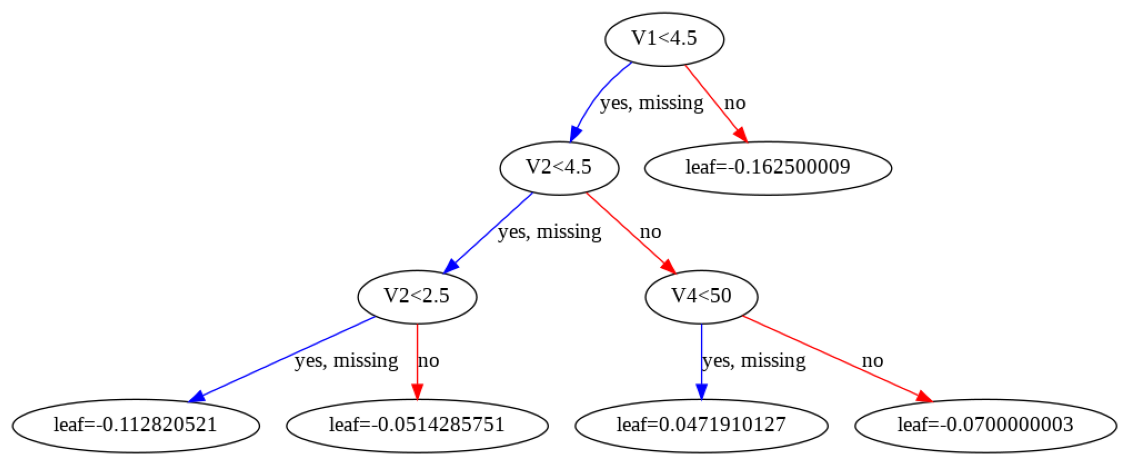

In [30]:
# 特徴量の重要度
print(classifier.feature_importances_)

# 木の可視化
_, ax = plt.subplots(figsize=(20, 20))
plot_tree(booster=classifier, ax=ax)

## sklearnの評価関数

In [13]:
# 予測結果の取得
train_y_pred = classifier.predict(train_X)
val_y_pred = classifier.predict(val_X)
test_y_pred = classifier.predict(test_X)

train_report = classification_report(y_true=train_y, y_pred=train_y_pred)
val_report = classification_report(y_true=val_y, y_pred=val_y_pred)
test_report = classification_report(y_true=test_y, y_pred=test_y_pred)

print(train_report)
print('----- -----')
print(val_report)
print('----- -----')
print(test_report)



              precision    recall  f1-score   support

           0       0.85      0.91      0.88       366
           1       0.62      0.47      0.54       112

    accuracy                           0.81       478
   macro avg       0.74      0.69      0.71       478
weighted avg       0.80      0.81      0.80       478

----- -----
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        92
           1       0.48      0.36      0.41        28

    accuracy                           0.76       120
   macro avg       0.65      0.62      0.63       120
weighted avg       0.74      0.76      0.75       120

----- -----
              precision    recall  f1-score   support

           0       0.78      0.97      0.87       112
           1       0.70      0.18      0.29        38

    accuracy                           0.77       150
   macro avg       0.74      0.58      0.58       150
weighted avg       0.76      0.77      0.72       